In [41]:
import numpy as np
import pandas as pd

import datetime

import matplotlib.pyplot as plt

In [42]:
!wget -P ./dataset --no-check-certificate --content-disposition https://raw.githubusercontent.com/MLPills/missing-values-and-detrending/main/dataset/monthly-beer-production-in-austr.csv

--2023-12-01 12:22:09--  https://raw.githubusercontent.com/MLPills/missing-values-and-detrending/main/dataset/monthly-beer-production-in-austr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6426 (6.3K) [text/plain]
Saving to: ‘./dataset/monthly-beer-production-in-austr.csv.1’

monthly-beer-produc 100%[===================>]   6.28K  --.-KB/s    in 0s      

2023-12-01 12:22:09 (36.4 MB/s) - ‘./dataset/monthly-beer-production-in-austr.csv.1’ saved [6426/6426]



In [43]:
df = pd.read_csv("dataset/monthly-beer-production-in-austr.csv")

In [44]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [45]:
df.dtypes

Month                       object
Monthly beer production    float64
dtype: object

In [46]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

In [47]:
df.dtypes

Month                      datetime64[ns]
Monthly beer production           float64
dtype: object

In [48]:
df = df.set_index('Month')

In [49]:
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [50]:
df_beer = df['Monthly beer production']

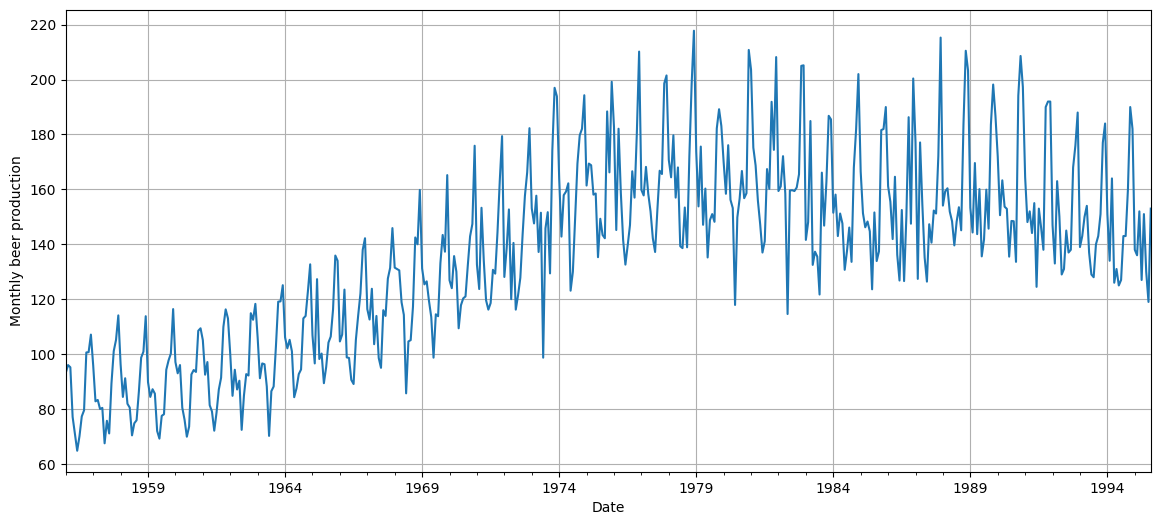

In [51]:
import matplotlib.pyplot as plt

df_beer.plot(figsize=(14,6))
plt.xlabel('Date')
plt.ylabel('Monthly beer production')
plt.grid()
plt.show()

In [52]:
df_beer.isna().sum()

0

In [53]:
df_beer = df_beer.diff()

In [54]:
df_beer = df_beer.dropna()

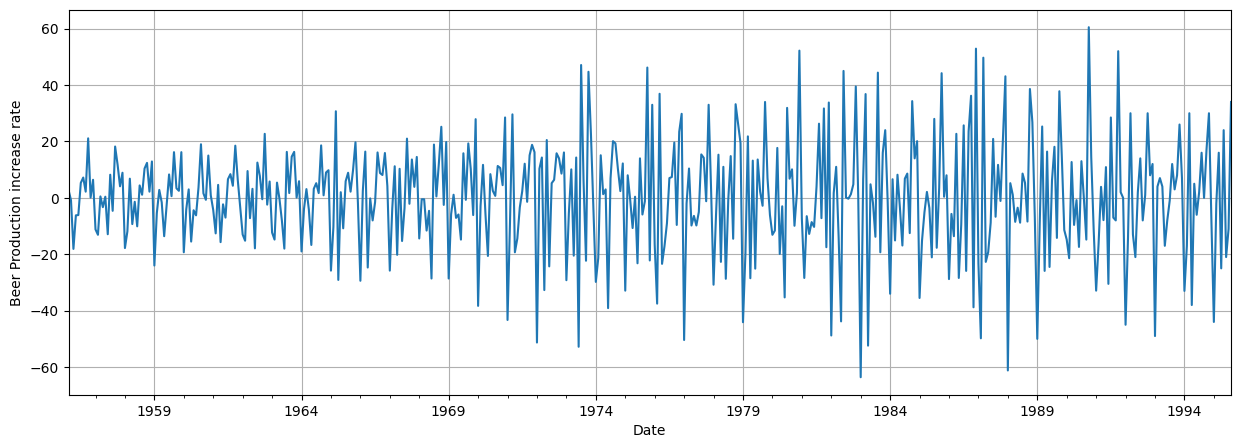

In [55]:
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Beer Production increase rate')
plt.grid()
plt.show()

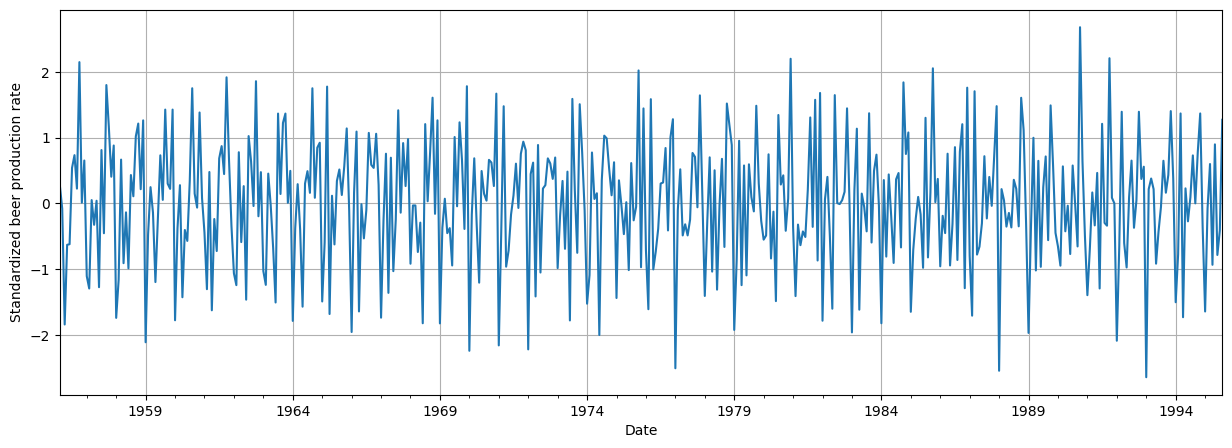

In [56]:
annual_variance = df_beer.groupby(df_beer.index.year).std()
mapped_annual_variance = df_beer.index.map(
    lambda x: annual_variance.loc[x.year])

df_beer = df_beer / mapped_annual_variance

df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Standardized beer production rate')
plt.grid()
plt.show()

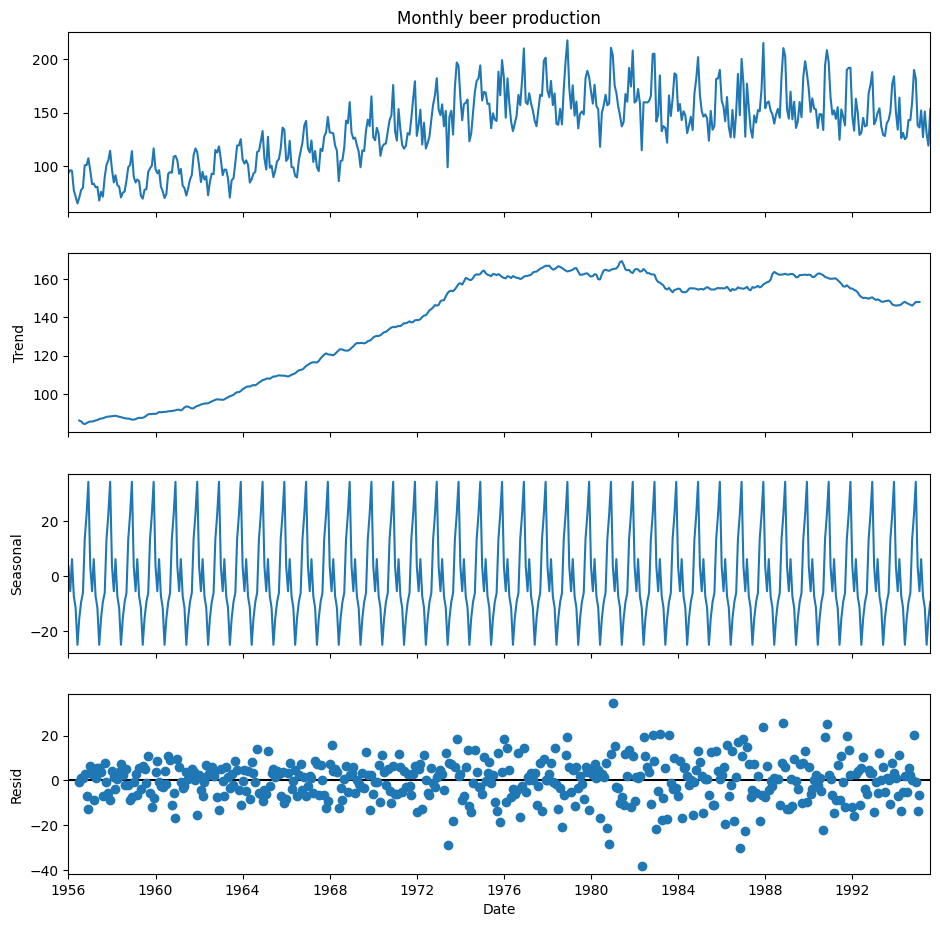

In [57]:
import statsmodels.api as sm

decomp = sm.tsa.seasonal_decompose(
    df['Monthly beer production'], period=12)
decomp_plot = decomp.plot()
plt.xlabel('Date')
decomp_plot .set_figheight(10)
decomp_plot .set_figwidth(10)
plt.show()

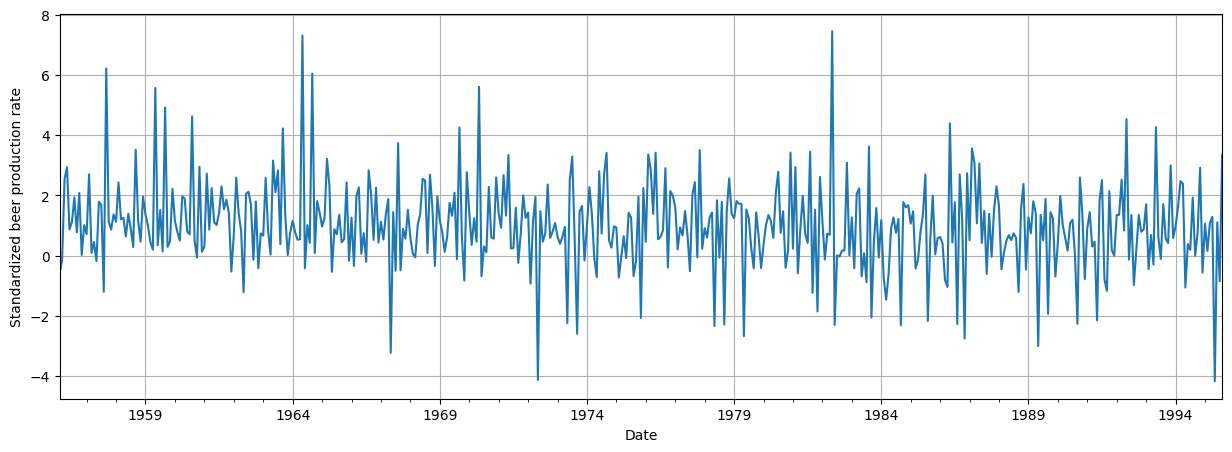

In [58]:
monthly_average = df_beer.groupby(df_beer.index.month).mean()
mapped_monthly_average = df_beer.index.map(
    lambda x: monthly_average.loc[x.month])

df_beer = df_beer / mapped_monthly_average

df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Standardized beer production rate')
plt.grid()
plt.show()

In [59]:
# import required libraries
from statsmodels.tsa.stattools import adfuller, kpss

# Perform ADF test
result = adfuller(df_beer)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# perform KPSS test
result = kpss(df_beer)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

ADF test:	p-value: 0.001
KPSS test:	p-value: 0.010


<ipython-input-59-57530119b921>:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df_beer)


In [60]:
df_beer = df_beer.diff()[1:]


result = adfuller(df_beer)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))


result = kpss(df_beer)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

ADF test:	p-value: 0.000
KPSS test:	p-value: 0.100


<ipython-input-60-5c7e49f53994>:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df_beer)


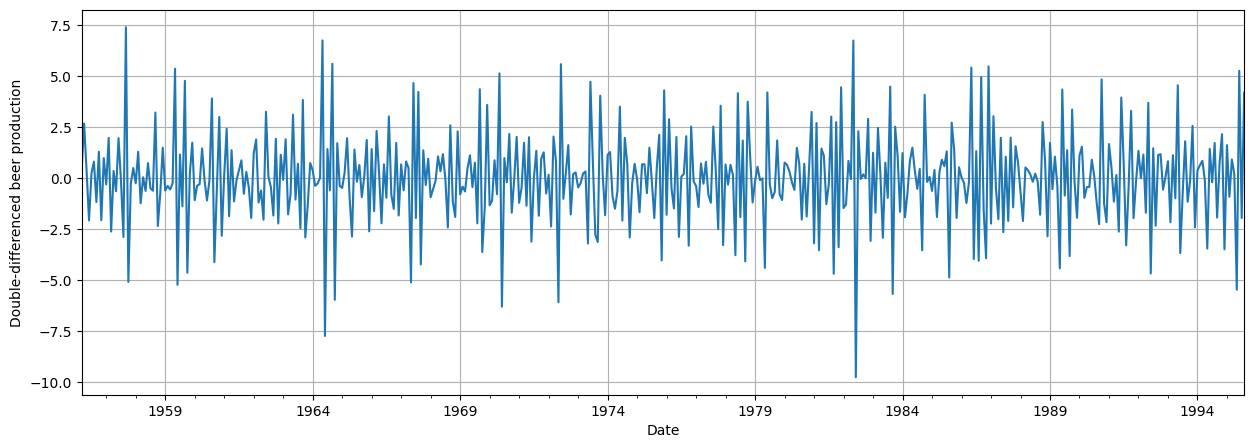

In [61]:
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Double-differenced beer production')
plt.grid()
plt.show()

In [62]:
mean = df_beer.mean()
std = df_beer.std()
df_beer = (df_beer - mean) / std

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
array_beer = df_beer.values.reshape(-1,1)
data_scaled = scaler.fit_transform(array_beer)
df_beer = pd.Series(data_scaled.flatten(),
                    index=df_beer.index, name='Month')

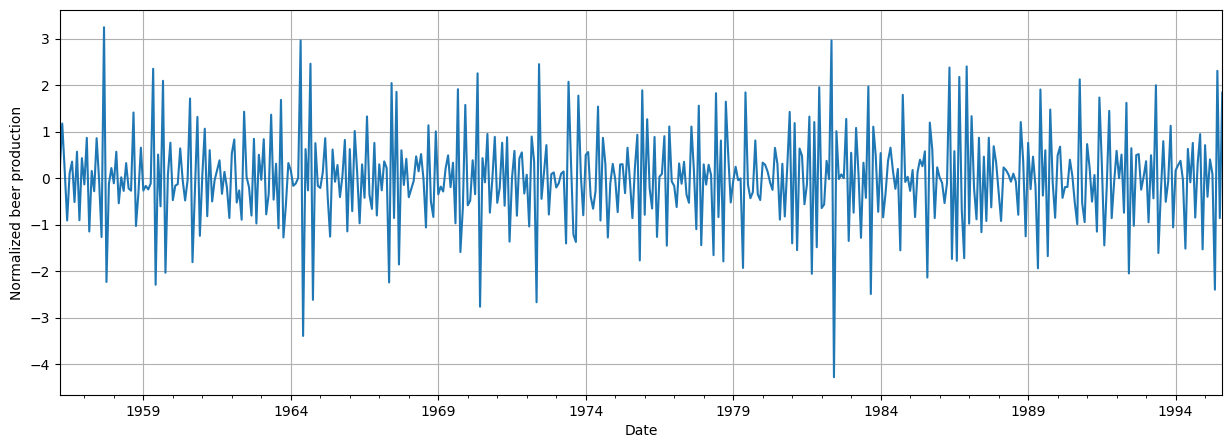

In [67]:
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Normalized beer production')
plt.grid()
plt.show()

In [69]:
df_beer = df_beer.to_frame()
df_beer.columns = ['Production']

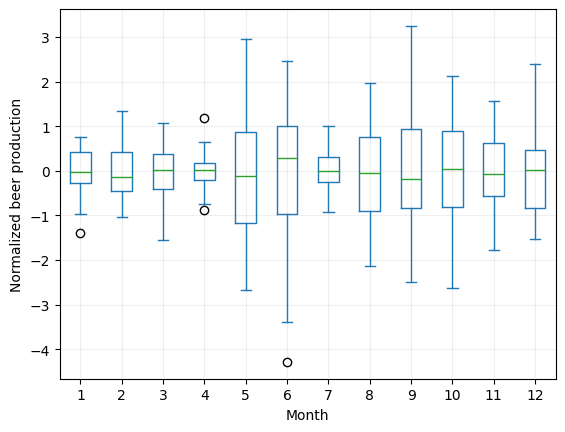

In [70]:
df_beer.set_index(df_beer.index.month, append=True).Production.unstack().plot.box()
plt.xlabel('Month')
plt.ylabel('Normalized beer production')
plt.grid(which='both', alpha=0.2)
plt.show()

In [76]:
abnormal_values_dates = []

for month in range(13):

  df_month = df_beer[df_beer.index.month == month]

  q1 = df_month.Production.quantile(0.25)
  q3 = df_month.Production.quantile(0.75)
  iqr = q3 - q1

  abnormal_dates = df_month[(df_month.Production < q1 - 1.5 * iqr)
                            | (df_month.Production > q3 + 1.5 * iqr)].index

  if not abnormal_dates.empty:
    abnormal_values_dates = abnormal_values_dates + list(abnormal_dates)


In [78]:
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z
window_size = 24
df_zscore = zscore(df_beer, window_size)
threshold = 3
abnormal_values_dates = abnormal_values_dates + \
    list(df_zscore[abs(df_zscore.Production) > threshold].index)

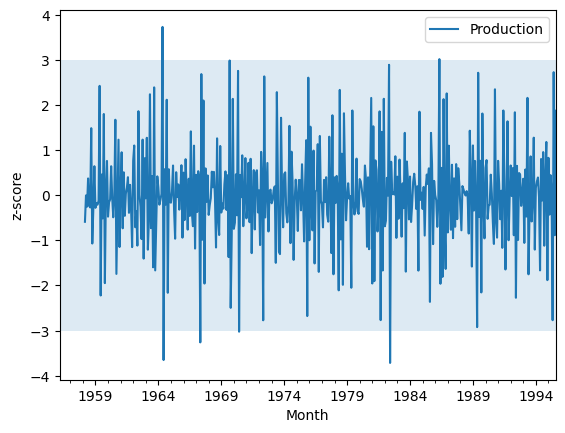

In [80]:
df_zscore.plot()
plt.fill_between(df_zscore.index.values, -3, 3, alpha=0.15)
plt.ylabel('z-score')
plt.show()

In [81]:
df_beer.loc[abnormal_values_dates, 'Production'] = np.nan

In [82]:
df_beer = df_beer.interpolate()

In [84]:
monthly_avg = df_beer.groupby(df_beer.index.month).mean()
for month in monthly_avg.index:
  df_beer.loc[df_beer.index.month == month, 'Production'] = \
      df_beer.loc[df_beer.index.month == month, 'Production'].fillna(
          monthly_avg.loc[month, 'Production'])

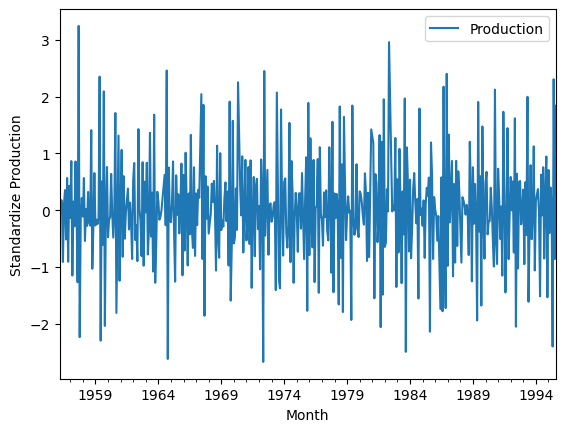

In [85]:
df_beer.plot()
plt.ylabel('Standardize Production')
plt.show()